In [1]:
# Cài đặt các thư viện cần thiết
!pip install pandas numpy scikit-learn tensorflow matplotlib

In [2]:
# Import các thư viện cần thiết
import pandas as pd  # Để xử lý dữ liệu dạng bảng
import numpy as np   # Để tính toán số học
from sklearn.preprocessing import MinMaxScaler  # Để chuẩn hóa dữ liệu
from tensorflow.keras.models import Sequential  # Để tạo mô hình neural network
from tensorflow.keras.layers import LSTM, Dense, Dropout  # Các layer cho mô hình
import matplotlib.pyplot as plt  # Để vẽ biểu đồ

In [5]:
# Bước 1: Tải file lên
from google.colab import files
uploaded = files.upload()

Saving PNJ.csv to PNJ.csv


In [7]:
# Đọc dữ liệu từ file CSV
# Thay 'PNJ.csv' bằng tên file đã tải lên
df = pd.read_csv('PNJ.csv')
df.head(100)

,Ticker,Date/Time,Open,High,Low,Close,Volume,Open Interest
0,PNJ,2/28/2018 9:15,78.14,78.99,78.14,78.99,270,0
1,PNJ,2/28/2018 9:16,78.94,78.94,78.94,78.94,10,0
2,PNJ,2/28/2018 9:19,78.14,78.14,78.14,78.14,283,0
3,PNJ,2/28/2018 9:20,78.14,78.14,78.14,78.14,480,0
4,PNJ,2/28/2018 9:21,78.14,78.14,78.14,78.14,146,0
...,...,...,...,...,...,...,...,...
95,PNJ,3/1/2018 9:17,78.61,78.61,78.14,78.61,129,0
96,PNJ,3/1/2018 9:18,78.61,78.61,78.61,78.61,42,0
97,PNJ,3/1/2018 9:20,78.14,78.14,78.14,78.14,225,0
98,PNJ,3/1/2018 9:21,78.14,78.14,78.14,78.14,95,0


In [8]:
# Xử lý dữ liệu, chuyển đổi thành giá mở - đóng cửa trong 1 ngày
# Chuyển đổi cột Date/Time sang định dạng datetime
df['Date/Time'] = pd.to_datetime(df['Date/Time'])

# Tạo cột Date chỉ chứa ngày (bỏ giờ phút giây)
df['Date'] = df['Date/Time'].dt.date

# Tạo DataFrame mới chứa dữ liệu theo ngày
daily_prices = pd.DataFrame()
# Lấy ngày đầu tiên của mỗi nhóm
daily_prices['Date'] = df.groupby('Date')['Date'].first()
# Lấy giá mở cửa đầu tiên của mỗi ngày
daily_prices['Open'] = df.groupby('Date')['Open'].first()
# Lấy giá đóng cửa cuối cùng của mỗi ngày
daily_prices['Close'] = df.groupby('Date')['Close'].last()

# Reset index để có index từ 0
daily_prices = daily_prices.reset_index(drop=True)


In [9]:
# Chuẩn hóa dữ liệu về khoảng [0,1]
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(daily_prices[['Close']])


In [10]:
# Chuẩn bị dữ liệu cho LSTM
look_back = 10  # Số ngày nhìn lại để dự đoán
X, y = [], []
for i in range(len(scaled_data) - look_back):
    X.append(scaled_data[i:(i + look_back), 0])  # Lấy 10 ngày liên tiếp
    y.append(scaled_data[i + look_back, 0])      # Lấy giá của ngày thứ 11
X, y = np.array(X), np.array(y)

In [11]:
# Chia dữ liệu thành tập train (80%) và test (20%)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [13]:
# Reshape dữ liệu cho LSTM [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [14]:
# Xây dựng mô hình LSTM
model = Sequential([
    # Layer LSTM đầu tiên với 50 units, trả về chuỗi để kết nối với LSTM tiếp theo
    LSTM(50, return_sequences=True, input_shape=(look_back, 1)),
    Dropout(0.2),  # Dropout để tránh overfitting
    # Layer LSTM thứ hai
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    # Layer output với 1 node (dự đoán giá)
    Dense(1)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [15]:
# Compile mô hình với optimizer adam và hàm loss là MSE
model.compile(optimizer='adam', loss='mse')

In [16]:
# Huấn luyện mô hình
history = model.fit(
    X_train, y_train,
    epochs=100,          # Số lần huấn luyện
    batch_size=32,       # Số mẫu mỗi lần cập nhật
    validation_split=0.1,  # 10% dữ liệu train dùng làm validation
    verbose=0
)

In [17]:
# Dự đoán trên tập train và test
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


In [18]:
# Chuyển đổi kết quả dự đoán về giá gốc (inverse transform)
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train_orig = scaler.inverse_transform([y_train])
y_test_orig = scaler.inverse_transform([y_test])

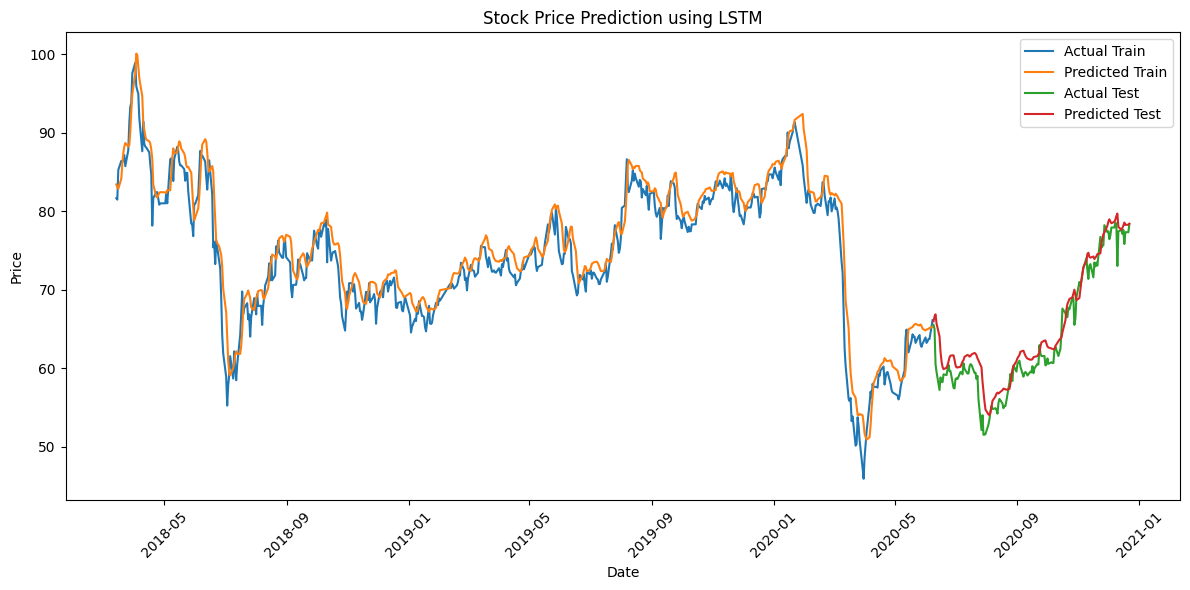

In [19]:
# Vẽ biểu đồ kết quả
plt.figure(figsize=(12, 6))
# Vẽ dữ liệu train
plt.plot(daily_prices['Date'][look_back:train_size+look_back],
         y_train_orig.T, label='Actual Train')
plt.plot(daily_prices['Date'][look_back:train_size+look_back],
         train_predict, label='Predicted Train')
# Vẽ dữ liệu test
plt.plot(daily_prices['Date'][train_size+look_back:],
         y_test_orig.T, label='Actual Test')
plt.plot(daily_prices['Date'][train_size+look_back:],
         test_predict, label='Predicted Test')

# Thiết lập tiêu đề và nhãn
plt.title('Stock Price Prediction using LSTM')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [20]:
# Tính toán độ lỗi RMSE
train_rmse = np.sqrt(np.mean((train_predict - y_train_orig.T) ** 2))
test_rmse = np.sqrt(np.mean((test_predict - y_test_orig.T) ** 2))
print(f'Train RMSE: {train_rmse:.2f}')
print(f'Test RMSE: {test_rmse:.2f}')

Train RMSE: 2.63
Test RMSE: 2.25
